In [1]:
import sys
sys.path.insert(0, "/media/giuseppec/25F62A4E5FEED162/work/temporalis_update/brightway2-temporalis_last")

In [2]:
from bw2temporalis import TemporalDistribution
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
import os
# pre='/media/giuseppec/25F62A4E5FEED162/work/papers/forest_paper/calculations/conversion_files/countr_ecor_correspondence.csv'
import pickle
from multi_key_dict import multi_key_dict
# from addict import Dict

from IPython.display import display, HTML
% matplotlib inline

from bw2temporalis.dyn_methods.metrics import RadiativeForcing
from bw2temporalis.dyn_methods.constants import co2_rf_td
import seaborn as sns
import palettable



t0=2010
this_folder=os.path.abspath(os.path.dirname('__file__'))
calc_fold=os.path.abspath(os.path.join(this_folder, '..'))
efolci=os.path.join(calc_fold,'lca_data/efolci.xls')
forest_data_xls=os.path.join(calc_fold,'data_forest/xls')
bw2_db_folder=os.path.join(calc_fold,'bw2_db')
proxies=os.path.join(forest_data_xls,'proxies')


efolci_int='interventions.xls'
efolci_gen='general_information.xls'



from brightway2 import *
projects.set_current('forest_lca')

In [3]:
#import general and internvetiosn leave only quality value A or B and delete unmanaged forests
gene=pd.read_excel(efolci_gen)[(pd.read_excel(efolci_gen)['QA'].isin(['A','B'])) & (pd.read_excel(efolci_gen)['Man_syst']!='Unmanaged forests')]
inter=pd.read_excel(efolci_int)#[(pd.read_excel(efolci_int)['QA'].isin(['A','B'])) & (pd.read_excel(efolci_int)['Management system']!='Unmanaged forests')]
inter=pd.merge(gene[['Country', 'Man_syst', 'Sp_group']],inter,how='left',on=['Country', 'Man_syst', 'Sp_group'])


### create db

In [ ]:
#for the file interventions of efolci
def merge_efolci(filepath_efo,filepath_gen,export=False):
    """merge the file with general informations and the ones with internvetions and export only needed
    cols"""
    
    finalis=pd.read_excel(filepath_efo)[['Country', 'Man_syst', 'Sp_group', 'Equip_1', 'Equip_2',
                                         'h/ha_1', 'm3/h_1', 'fresh_t/h_1','h/ha_2', 'm3/h_2','fresh_t/h_2','type_of_interv']]
    
    #rename just to avoid changing everything cause prpeviously used another naming
    finalis.columns=['Country', 'Management system', 'Species group', 'type_of_main_equipment', 'Type of Additional equipment','h/ha', 'm3/h', 'fresh t/h',
       'h/ha 2', 'm3/h 2','fresh t/h 2','type_of_intervention']
    
    
    #create col intervention
#     finalis.intervention=np.nan
    finalis.loc[finalis.type_of_intervention.isin(["clear cutting","plentering","final felling","final cutting",
                                                   "harvesting","preparatory felling","regeneration felling","secondary felling",
                                                 "selection felling","seedling felling"]
                                                 ),'intervention'] = "final felling"
    
    finalis.loc[finalis.type_of_intervention.isin(["planting","Pre-commercial thinning","beating-up","browsing control",
                                                   "Building game protection fence","building game protection fence",
                                                   "cleaning","cleaning forest area from branches","clearing","disking",
                                                   "Enrichment planting","exoctic species control","stump destruction",
                                                   "stump lifting","exotic species control","Individual game protection",
                                                   "Mound Plowing","partial schreding","Protection",
                                                   "shredding","site preparation","weed control","scarification",
                                                   "Forest care","pruning","pest control"]
                                                 ),'intervention'] = "planting"
    
    finalis.loc[finalis.type_of_intervention.isin(["tending","thinning"]
                                                 ),'intervention'] ="thinning"
    
    #create col for PG system of klein
    finalis.loc[finalis.type_of_intervention.isin(["clear cutting","final felling","final cutting","harvesting","preparatory felling",
                                                   "regeneration felling","secondary felling","plentering", "felling","selection felling",
                                                   "seedling felling","thinning","tending", #put here tending cause in true are thinnings in efolci
                                                    ]),'system'] = "harvesting"

    finalis.loc[finalis.type_of_intervention.isin(["planting","clearing","disking","site preparation","scarification","Mound Plowing",
                                                   "Individual game protection","Protection",
                                                "stump destruction","stump lifting", #put here to be consistent with my classification (i.e`intervention`.)
                                                  ]
                                                ),'system'] = "planting"


    finalis.loc[finalis.type_of_intervention.isin(["cleaning","cleaning forest area from branches","pruning","pest control","exotic species control",
                                                   "Building game protection fence", "building game protection fence","browsing control","Forest care",
                                                   "partial schreding","shredding","weed control","Pre-commercial thinning","exoctic species control",
                                                    "Enrichment planting","beating-up"]),'system'] = "tending" #check this two
    
    
    #import finalissimo
#     finalis=pd.read_excel(filepath_efo)[['Country', 'Management system', 'Species group', 'type_of_main_equipment', 'Type of Additional equipment',
#                                          'h/ha', 'm3/h', 'fresh t/h','h/ha 2', 'm3/h 2','fresh t/h 2','intervention','type_of_intervention']]
    #import general
    gen=pd.read_excel(filepath_gen)[[ 'Country', 'Man_syst', 'Sp_group','Staff','Dens','Road','Reg','QA']]#,'equip', 'harv staff', 'road', 'trail']]
    #change clearcut name (NOT NEEDED ANYMORE)
#     gen.Man_syst.replace({'Even-aged forest: Uniform clear-cut system':'Even-aged forest-Uniform clear-cut system'},inplace=True)
    
    #change col names
    gen.rename(columns={k:v for k,v in zip(['Country', 'Man_syst', 'Sp_group'],
                                               ['Country', 'Management system', 'Species group'])},inplace=True)
    
    #merge the two
    efo=finalis.merge(gen,how='left',on=['Country', 'Management system', 'Species group']) #left to skip unmanaged
    
    #leave only quality value A or B and delete unmanaged forests
    efo=efo[(efo['QA'].isin(['A','B'])) & (efo['Management system']!='Unmanaged forests')]

    if export:
        efo.to_excel('efolci.xls',index=False)
    return efo

efo=merge_efolci(efolci_int,efolci_gen)

In [ ]:
#with also the systems of klein that are defined in the file `0_some data preparation` (need to be done based on efolci not finalissimo as the two below)

def reshape_and_avg(df_final):
    """function that reshape putting from wide to long the machineuries used and the productivities and calcualte the average
    of the latter"""
    
    #split first and second machienry
    mach_1=df_final[['Country', 'Management system', 'Species group','Reg', 'type_of_main_equipment', 'h/ha',
                     'm3/h', 'fresh t/h','intervention', 'system','type_of_intervention']]
    mach_2=df_final[['Country', 'Management system', 'Species group','Type of Additional equipment','h/ha 2', 'm3/h 2',
                     'fresh t/h 2','intervention', 'system','type_of_intervention']]
    
    #put from wide to long
    mach_1=pd.melt(mach_1,id_vars=['Country', 'Management system', 'Species group', 'Reg','type_of_main_equipment','intervention', 'system','type_of_intervention'],
                   value_vars=['h/ha', 'm3/h', 'fresh t/h'],var_name='productivity')
    mach_1.dropna(subset=['value'],inplace=True)
    
    mach_2=pd.melt(mach_1,id_vars=['Country', 'Management system', 'Species group', 'Reg','Type of Additional equipment','intervention', 'system','type_of_intervention'],
                   value_vars=['h/ha 2', 'm3/h 2','fresh t/h 2'],var_name='productivity')
    mach_2.dropna(subset=['value'],inplace=True)
    
    mach_2.rename(columns={'Type of Additional equipment':'type_of_main_equipment'},inplace=True)
    #remerge the two
    mach_both=pd.concat([mach_1,mach_2])
    #calculate average
        #the 'dummy' below is needed otherwise when NaNs are present in the groups the rows are skipped
    mach_avg=mach_both.fillna('dummy').groupby(
                            ['Country', 'Management system', 'Species group','Reg','intervention', 'system','type_of_intervention','type_of_main_equipment','productivity']
                            ).mean().reset_index()
    # put from long to wide productivity
    mach_avg = mach_avg.pivot_table(
        index=['Country', 'Management system', 'Species group','Reg','intervention', 'system','type_of_intervention','type_of_main_equipment'],
        columns=['productivity']).reset_index().replace('dummy', np.nan)

# #         #flatten the multilevel dataframe
    mach_avg.columns = list(mach_avg.columns.get_level_values(0)[:8]) + list(mach_avg.columns.get_level_values(1)[-3:]) #see http://stackoverflow.com/a/14508355/4929813
    
    
    #average and append also staff
    staff=df_final.groupby(['Country', 'Management system', 'Species group'])['Staff'].mean().reset_index()
    mach_avg=mach_avg.merge(staff,how='left',on=['Country', 'Management system', 'Species group'])
        #change 0 and nan in staff with average staff transport
    mach_avg.Staff=mach_avg.Staff.fillna(mach_avg.Staff.mean())
    mach_avg.Staff=mach_avg.Staff.replace({0:mach_avg.Staff.mean()})
    
    #add also planting density
    dens=df_final.groupby(['Country', 'Management system', 'Species group'])['Dens'].mean().reset_index()    
    mach_avg=mach_avg.merge(dens,how='left',on=['Country', 'Management system', 'Species group'])
    
#         #change 0 and nan in dens with 2000
    mach_avg.Dens=mach_avg.Dens.fillna(2000)
    mach_avg.Dens=mach_avg.Dens.replace({0:2000})
    
    
    #average and append also Road density
    Road=df_final.groupby(['Country', 'Management system', 'Species group'])['Road'].mean().reset_index()
    mach_avg=mach_avg.merge(Road,how='left',on=['Country', 'Management system', 'Species group'])
        #change 0 and nan in staff with average staff transport
    mach_avg.Road=mach_avg.Road.fillna(mach_avg.Road.mean())
    mach_avg.Road=mach_avg.Road.replace({0:mach_avg.Road.mean()})
    
    
    return mach_avg

fina_avg=reshape_and_avg(efo)




In [4]:
#caclualte total harvests (tot) and harvest divided by thinnings and fellings and planting area(harv)


harv=inter[['Country', 'Man_syst', 'Sp_group','type_of_interv' ,'m3_ob_Logs', 'm3_ob_Firewood','m3_ob_pulp', 'Loose_m3_chips']]
harv['Loose_m3_chips']=harv['Loose_m3_chips']/2.5 #convert to wood

#calcualte total and remove interventions without harvesting
harv['rem']=harv[['m3_ob_Logs', 'm3_ob_Firewood','m3_ob_pulp', 'Loose_m3_chips']].sum(axis=1)
harv.dropna(subset=['rem'],inplace=True)
harv['int']=np.where(harv['type_of_interv'].isin(['thinning',  'tending',]),'all_thin_vol_FU','fcut_vol_FU' )
harv=harv[['Country', 'Man_syst', 'Sp_group', 'int','rem']]
harv=harv.groupby(['Country', 'Man_syst', 'Sp_group' ,'int']).sum().reset_index()

#caalcualte tot m3 per FOU
tot=harv.groupby(['Country', 'Man_syst', 'Sp_group']).sum().reset_index()

#rename
tot.rename(columns={k:v for k,v in zip(['Country', 'Man_syst', 'Sp_group'],
                                               ['Country', 'Management system', 'Species group'])},inplace=True)

harv=harv.pivot_table(index= ['Country', 'Man_syst', 'Sp_group'], columns='int', values='rem').reset_index()

#add fake year 0
harv['YEAR']=0

plant=gene[['Country', 'Man_syst', 'Sp_group','Reg']]


#calcualte planting density
plant['AREA_planted_now']=np.where(plant['Reg'].isin(['natural+artificial from plantation',  'artificial from plantation', 'artificial from sowing',
       'natural+artificial from sowing']),1,0 )

harv=pd.merge(harv,plant[['Country', 'Man_syst', 'Sp_group','AREA_planted_now']],how='outer',on=['Country', 'Man_syst', 'Sp_group'])


harv.rename(columns={k:v for k,v in zip(['Country', 'Man_syst', 'Sp_group'],
                                               ['country', 'MANAGE_SYSTEM', 'SP_GROUP'])},inplace=True)


harv.fillna(0,inplace=True)
# harv
#return harv,tot



/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [ ]:
def merge_forest_quest(df_f,df_quest):
    """merge and already calculate distance for staff in manual"""
    merged=df_f.merge(df_quest.rename(columns={'Country':'country','Management system':'MANAGE_SYSTEM','Species group':'SP_GROUP'}),
             how='left',on=['country','MANAGE_SYSTEM','SP_GROUP']).sort_values(['country','MANAGE_SYSTEM','SP_GROUP','YEAR','intervention'])
    return merged


merged=merge_forest_quest(harv,fina_avg)


In [ ]:
#FUNCTIONS ND DICTIONARIES USED BELOW


#dictionary with type of unit process or material to use for each item reported in efolci
machine_ei_dic= {#ecoinvent
                 'chainsaw': ('ecoinvent 3.2 cutoff', '6f92a099bc0888354162e2317cadfab9'), #power sawing, with catalytic converter, RER
                 'feller buncher': ('ecoinvent 3.2 cutoff','d428a52f10ff638e59ddc1496fad29dd'), #harvesting, forestry harvester, RER
                 'forwarder': ('ecoinvent 3.2 cutoff', '72479f564ab484d65e309fe13cc5aee5'), #forwarding, forwarder RER
                 'harvester': ('ecoinvent 3.2 cutoff', 'd428a52f10ff638e59ddc1496fad29dd'), #harvesting, forestry harvester, RER
                 'skidder': ('ecoinvent 3.2 cutoff', 'cdc06a3b7056096d597d5d72d15cf7bc'), #skidding, skidder RER
                 'wood chipper': ('ecoinvent 3.2 cutoff', 'e7ee673ffb60fd889d5b5937566ac66a'), # wood chipping, terrain chipper, diesel, RER
                 'yarder': ('ecoinvent 3.2 cutoff', 'a60bfd9e6fa24c029d5d0fad5e4fc75e'), # yarding, mobile cable yarder on trailer
                 'stump grinder': ('ecoinvent 3.2 cutoff', '2a0656fcd1c7c72ad148f8feb909394e'), #delimbing, with excavator-based processor, RER


                 #agribalyse
                 'forwarder and ripper': ('agribalyse 1.3', 'e3c2ab57045cb5dc38fa1e68a54e13a6'), #agribalyse Soil decompactation/hr/FR/hr/FR (with Decompacting soil, 5 shank subsoiler) similar l/hr of what reported in efolci
                 'ripper': ('agribalyse 1.3', 'e3c2ab57045cb5dc38fa1e68a54e13a6'), #agribalyse Soil decompactation/hr/FR/hr/FR (with Decompacting soil, 5 shank subsoiler) similar l/hr of what reported in efolci
                 'tractor and ripper': ('agribalyse 1.3', 'e3c2ab57045cb5dc38fa1e68a54e13a6'), #agribalyse Soil decompactation/hr/FR/hr/FR (with Decompacting soil, 5 shank subsoiler) similar l/hr of what reported in efolci
                 'cultivator':('agribalyse 1.3', 'c1773a7509f1b1cb6aad264c32f42ae5'), #agribalyse Soil decompactation, with cultivator' (hour, FR
                 'mulcher': ('agribalyse 1.3', '8c6de22b5782428ede8a3fdc5c502e79'), #agribalyse Crushing, with shredder' (hour, FR)
                 'tractor and shredder': ('agribalyse 1.3', '8c6de22b5782428ede8a3fdc5c502e79'), #agribalyse Crushing, with shredder' (hour, FR)
                 'tractor and plough': ('agribalyse 1.3', '7a0fab39b19636e1e7dce4f48541b756'), # agribalyse Tillage, ploughing, tree nursery (hour, FR
                 'sprayer': ('agribalyse 1.3', '2143e49efb65f8703e5682cef31f747c'), #agribalyse Plant protection, spraying, with knapsack sprayer,hour
                 'tractor and disk': ('agribalyse 1.3', 'ba83ebefc4a724507cff601bbb9197b0'), #agribalyse 'Soil preparation, with disc harrow' (hour, FR
                 'tracter and planter': ('agribalyse 1.3', 'b8e60a4158e6717d233833fac1bd65df'), # agribalyse Sowing or planting, trees (orchard)' (hour, FR, None)
                 'tractor and planter': ('agribalyse 1.3', 'b8e60a4158e6717d233833fac1bd65df'), # agribalyse Sowing or planting, trees (orchard)' (hour, FR, None)
                 'tractor': ('agribalyse 1.3', 'c1863edd89688fb9ff4ab160da280e7e'), #Pushing wood, with small tractor/hr/FR 
                 'tractor with attachemnt for seedlings transportation': ('agribalyse 1.3', 'c1863edd89688fb9ff4ab160da280e7e'), #Pushing wood, with small tractor/hr/FR
                 'harrow': ('agribalyse 1.3', 'c1f3aa10b58fed271e9a24446f372c1a'), # agribalyse Harrowing, with small tractor (orchard) (hour, FR)
                 'machine for mechanized planting': ('agribalyse 1.3', 'b8e60a4158e6717d233833fac1bd65df'), # agribalyse Sowing or planting, trees (orchard)' (hour, FR, None)
                 'tractor and skidder': ('agribalyse 1.3', 'c1863edd89688fb9ff4ab160da280e7e'), #Pushing wood, with small tractor/hr/FR #otherwise ('ecoinvent 3.2 cutoff',  'cdc06a3b7056096d597d5d72d15cf7bc'), #skidding, skidder RER
                 'excavator': ('agribalyse 1.3', 'cd5e0fe72a781fe4a5d8f7857638d557'), #agribalyse Indentation of pots, with tractopelle (i.e. digger/Back hoe)

                  #own
                 'brushing saw': ('modified','brusing_saw'),# modified version of the following: ('ecoinvent 3.2 cutoff', '6f92a099bc0888354162e2317cadfab9'), #power sawing, with catalytic converter, RER
                 'planter':  ('modified','small_machine'), # small self motorized machine with 2l/hour of consumption
                 'motor hoe': ('modified','small_machine'), # small self motorized machine with 2l/hour of consumption
                 'self walking seed planter':  ('modified','small_machine'), # small self motorized machine with 2l/hour of consumption

                 #manual activities
                 'manual': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'Manual': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'manual coating': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'manual planting': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'manual spade': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'Pneumatic pruning scissor': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'pruning saw': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'Hoe (manual)': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'pottiputki -planting tool': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 'bush saw': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                 #check what to do with this horses....normally if they are used is cause of the accessibility prob and thus also lorry cannot arrive, for now consider only staff transport
                 'horse': ('ecoinvent 3.2 cutoff', '5a3b816491e258d64496a4a3eca91956'), # transport, passenger car, large size, diesel, EURO 4
                }


extra_material={'fencing': ('ecoinvent 3.2 cutoff','3bdacd0ad813e0f96ea9ec73dcc6cb4a'), #aluminium around steel bi-metal wire, 3.67mm external diameter , meter
                'seeds':('ecoinvent 3.2 cutoff','41ed25c27f37dd9da82780b7a9e13cdd'), #tree seedling production, in unheated greenhouse [RER], unit 
                'gravel': ('ecoinvent 3.2 cutoff','39af7a20ac9e36162c21bdd1e298eb55'), #gravel crushed
                'diesel':('ecoinvent 3.2 cutoff','2128c93010a08498faaef7d24cbf16c3'), #diesel, burned in building machine MJ
                'gravel_transport': ('ecoinvent 3.2 cutoff','e93c7a36da909b067778b12260aefca9'), #transport, freight, lorry 7.5-16 metric ton, EURO5 tkm
                'transport_machine':('ecoinvent 3.2 cutoff','8e43be6b41e1fcf6be1aec6489ff9171'), #transport, freight, lorry 16-32 metric ton, EURO5
                'CO2':('biosphere3','cc6a1abb-b123-4ca6-8f16-38209df609be') # 'Carbon dioxide, in air' (kilogram, None, ('natural resource', 'in air'))
               }
manual=['manual',  'manual coating', 'manual planting', 'manual spade','Pneumatic pruning scissor','pruning saw', 'Hoe (manual)',
        'pottiputki -planting tool', 'bush saw', 'horse']

#create col for PG system of klein
# when change this change also the relative part in te file `0_some data preparation` (not needed but better for consistency)

syst = multi_key_dict()
syst["clear cutting","final cutting","harvesting","preparatory felling",
                                               "regeneration felling","secondary felling","plentering", "felling","selection felling",
                                               "seedling felling","tending", #put here tending cause in true are thinnings in efolci
                                                "thinning","final felling",#this two takes also the field `intervention` 
                                                ]="harvesting"

syst["planting","clearing","disking","site preparation","scarification","Mound Plowing",
                                                "stump destruction","stump lifting", #put here to be consistent with my classification (i.e`intervention`.)
                                               "Individual game protection","Protection"]= "planting"


syst["cleaning","cleaning forest area from branches","pruning","pest control","exotic species control",
                                               "Building game protection fence", "building game protection fence","browsing control","Forest care",
                                               "partial schreding","shredding","weed control","Pre-commercial thinning","exoctic species control",
                                                "Enrichment planting","beating-up",
                                                'road',#check if road correct here or somewhere else
                                                ] = "tending" #check this two



# syst["below",'above']= "biogenic"
        
#     new helper fucntion for klein
def create_exchange(db,db_name,ds_code,equipment,intervention_group,sub_df_col_year,sub_df_col_amount,dict_name_eiprocess,klein_code):
    """helper function used below to create exchanges (to avoid repeating everything every time)
    db:database
    ds_code: code of the dataset (e.g. FU_name)
    equipment: type_of_main_equipment
    intervention_group: intervention (or system if will change things later)
    df_col_year: column with the year of the sub df created without zero
    sub_df_col_amount:  column with the amount of the sub df created without zero
    dict_name_eiprocess: dictionary with the key as name of the item and value the ecoinvent process (e.g. machine_ei_dic or extra_material)
    klein_code:code of the klein's classification
    """

#         ds_name=ds_code[:-1] + (klein_code,)
    ds_name=ds_code + (klein_code,)
    db.setdefault((db_name, ', '.join(ds_name),), {}).setdefault('exchanges', []).append({                        
            'input': dict_name_eiprocess[equipment], 
            'machine_efolci': equipment, #machine name 
            'intervention': intervention_group, #intervention name 
            'name':get_activity(dict_name_eiprocess[equipment])['name'], #name of the 
            'type':'technosphere' if equipment != 'CO2' else 'biosphere' ,  
            'unit':'hours of use' if equipment != 'CO2' else 'kilogram',#this is not correct since things like gravel are not in hrs of use
            'temporal distribution': TemporalDistribution(sub_df_col_year.values.astype('timedelta64[Y]'), sub_df_col_amount.values),#correct
#                 'temporal distribution': TemporalDistribution(sub_df_col_year.values.astype('datetime64[Y]'), sub_df_col_amount.values),#correct but with datetime
#                 'temporal distribution': [sub_df_col_year.values, sub_df_col_amount.values],#this is just to print out in the .py file
            'amount':sub_df_col_amount.sum(),        
            }) 
    #add name and grouping for temporalis
    db.setdefault((db_name, ', '.join(ds_name),), {}).setdefault('name', ', '.join(ds_name))                       
    db.setdefault((db_name, ', '.join(ds_name),), {}).setdefault('tempo_group', True)  

In [ ]:
#this create one dataset per FU by classification klein
#
def create_db(df_avg,db_name):
    """function that create the bw2 db from the passed dataframe with the productivities averaged
    #SKIP UNMANAGED FORESTS IN FIRST PART AND ROAD,
    """    
#     #convert absolute to relative years
#     df_avg.YEAR=df_avg.YEAR-t0
    
    
    bw2_db={}                     


    for FU_name, FU_group in df_avg.groupby(['country', 'MANAGE_SYSTEM','SP_GROUP','intervention']):
        #here group by big group and 'intervention','type_of_main_equipment','type_of_intervention'
        for int_name, int_group in FU_group.groupby(['country', 'MANAGE_SYSTEM','SP_GROUP','intervention','type_of_main_equipment']):  
            
            #to avoid repeating everything two times use these 2 dict
            field_col={'thinning':'all_thin_vol_FU','final felling':'fcut_vol_FU','planting':'AREA_planted_now'}
            prod={'thinning':'m3/h','final felling':'m3/h','planting':'h/ha'}

            #calculate inputs (NEED SEPARATE CAUSE ONE MULTIPLY THE OTHER  DIVIDE)
#           #THINNING AND FELLINGS use m3/h
            if (int_name[3]=='thinning' and int_group[field_col[int_name[3]]].sum()!=0 ) or \
               (int_name[3]=='final felling' and int_group[field_col[int_name[3]]].sum()!=0) :
                if int_name[4] in manual: 
                    #calculate travelled distance for manual assuming a working day of 8 hours where the 2 person do the route 2 times
                    int_group['harv_amount']=int_group[field_col[int_name[3]]].div(int_group[prod[int_name[3]]]) / 4 #(i.e 8/2)
                    int_group['harv_amount']=int_group['harv_amount'].multiply(int_group['Staff'])
                else:
                    #just calculate hours of use
                    int_group['harv_amount']=int_group[field_col[int_name[3]]].div(int_group[prod[int_name[3]]])
                    
                #filter non zero amount for temporal distribution
                td_harv=int_group[['YEAR','harv_amount']].iloc[int_group['harv_amount'].nonzero()]
                #create exchanges
                create_exchange(bw2_db,db_name,FU_name[:-1],int_name[4],int_name[3],td_harv['YEAR'],td_harv['harv_amount'],machine_ei_dic,'harvesting')
                #add transport machinery for abgribalyse that is not included
                if machine_ei_dic[int_name[4]][0]=='agribalyse 1.3':
                    #calculate transort per hour and after total
                    transport_hour=8000/1000*25/8 #(weight in kg/1000(to convert tons)*km/hours per day) assume 8000 kg
                    td_harv['transport']=td_harv['harv_amount']*transport_hour 
                    create_exchange(bw2_db,db_name,FU_name[:-1],'transport_machine',int_name[3],td_harv['YEAR'],td_harv['transport'],extra_material,'harvesting')

            #PLANTING uses h/ha
            elif int_name[3]=='planting' and int_group[field_col[int_name[3]]].sum()!=0 :
                #loop by type of intervention (split here cause these cannot logically be combined)
                for plan_name, plan_group in FU_group.groupby(['country', 'MANAGE_SYSTEM','SP_GROUP','intervention',
                                                               'type_of_main_equipment','type_of_intervention']):
                    #deal with fencing (it is only manual )
                    if plan_name[5] in ['Individual game protection','Building game protection fence','building game protection fence']:
                        #calculate fencing amount
                        td_fen=plan_group[['YEAR','AREA_reg']]
                        td_fen['fencing']=(140/0.069663) * td_fen.AREA_reg  #140 kg/ha (from klein) divided by density to obtain meter used per ha regenerated
                        td_fen=td_fen[['YEAR','fencing']].iloc[td_fen['fencing'].nonzero()].dropna(subset=['fencing'])
                        #create exchanges
                        create_exchange(bw2_db,db_name,FU_name[:-1],'fencing',plan_name[3],td_fen['YEAR'],td_fen['fencing'],extra_material,syst[plan_name[5]])
                        
                    #deal with seeds for artificial planting (can be left here since there are no duplicates)
                    if plan_name[5] == 'planting':
                        td_seed=plan_group[['YEAR','AREA_planted_now','Dens']]
                        if len(td_seed)!=len(td_seed.drop_duplicates()):
                            print('in {} {} planting has duplicates'.format(db_name,plan_name))
#                         print(plan_name,td_seed.shape,td_seed.drop_duplicates().shape,'\n')
                        td_seed['seeds']=td_seed.Dens* td_seed.AREA_planted_now #calculate all the seeds used
                        td_seed=td_seed[['YEAR','seeds']].iloc[td_seed['seeds'].nonzero()].dropna(subset=['seeds'])
                        #create exchanges
                        create_exchange(bw2_db,db_name,FU_name[:-1],'seeds',plan_name[3],td_seed['YEAR'],td_seed['seeds'],extra_material,syst[plan_name[5]])

                    
                    #do all the rest i.e. deal with single machine used
                    if plan_name[4] in manual: 
                        #calculate travelled distance for manual assuming a working day of 8 hours where the 2 person do the route 2 times
                        plan_group['plan_amount']=plan_group[field_col[plan_name[3]]].multiply(plan_group[prod[plan_name[3]]]) / 4 #(i.e 8/2)
                        plan_group['plan_amount']=plan_group['plan_amount'].multiply(plan_group['Staff'])
                    
                    else:
                        #just calculate hours of use 
                        plan_group['plan_amount']=plan_group[field_col[plan_name[3]]].multiply(plan_group[prod[plan_name[3]]])
                    #filter non zero amount for temporal distribution
                    td_pl=plan_group[['YEAR','plan_amount']].iloc[plan_group['plan_amount'].nonzero()]
                    #create exchanges
                    create_exchange(bw2_db,db_name,FU_name[:-1],plan_name[4],plan_name[3],td_pl['YEAR'],td_pl['plan_amount'],machine_ei_dic,syst[plan_name[5]])
                    
                    #add transport machinery for abgribalyse that is not included
                    if machine_ei_dic[plan_name[4]][0]=='agribalyse 1.3':
                        #calculate transort per hour and after total
                        transport_hour=8000/1000*25/8 #(weight in kg/1000(to convert tons)*km/hours per day) assume 8000 kg
                        td_pl['transport']=td_pl['plan_amount']*transport_hour 
                        create_exchange(bw2_db,db_name,FU_name[:-1],'transport_machine',plan_name[3],td_pl['YEAR'],td_pl['transport'],extra_material,syst[plan_name[5]])

#     #del intervention without exchanges 
#     bw2_db={k:v for k,v in bw2_db.items() if bw2_db[k]['exchanges']}
                
    return bw2_db

forest_db=create_db(merged,'efolci')



In [ ]:
def merge_for_road_bio(san_df,df_quest):
    """merge and already calculate distance for staff in manual"""
    no_dup=df_quest.rename(columns={'Country':'country','Management system':'MANAGE_SYSTEM','Species group':'SP_GROUP'})[
                                    ['country','MANAGE_SYSTEM','SP_GROUP','Road']]
    no_dup.drop_duplicates(inplace=True)
    merg=san_df.merge(no_dup,
             how='left',on=['country','MANAGE_SYSTEM','SP_GROUP']).sort_values(['country','MANAGE_SYSTEM','SP_GROUP','YEAR'])
    return merg


road_bio=merge_for_road_bio(harv,fina_avg)




In [ ]:
def add_road(db,df_avg,db_name):
    """function that adds road maineinenace """
    #for road maintenance       
    for FU2_name, FU2_group in df_avg.groupby(['country', 'MANAGE_SYSTEM','SP_GROUP']): 
        #skip unamanged forest for forest roads
        if FU2_name[1]!='Unmanaged forests':
            td_road=FU2_group[['YEAR','Road']]
            #for gravel
            td_road['gravel']= (0.02* (td_road.Road*3.5)*1600)/15  #total gravel used= (thickness* area (i.e. lenght road*width)*density gravel*)/(interval road maintenance)
            td_road=td_road[['YEAR','gravel']].iloc[td_road['gravel'].nonzero()].dropna(subset=['gravel'])
            create_exchange(db,db_name,FU2_name,'gravel','road',td_road['YEAR'],td_road['gravel'],extra_material,syst['road'])
            #for diesel
            td_road['diesel']= td_road['gravel']*0.043 # diesel used to transport gravel
            create_exchange(db,db_name,FU2_name,'diesel','road',td_road['YEAR'],td_road['diesel'],extra_material,syst['road'])
            #gravel_transport
            td_road['gravel_transport']= (td_road['gravel']*50)/1000  #transport gravel 50 km and convert kg to tons
            create_exchange(db,db_name,FU2_name,'gravel_transport','road',td_road['YEAR'],td_road['gravel_transport'],extra_material,syst['road'])
                
    return db



db_road_bio=add_road(forest_db,road_bio,'efolci')



##########


sanna_file_BAU='/media/giuseppec/25F62A4E5FEED162/work/papers/forest_paper/calculations/data_forest/xls/BAU45_NOLIMIT_harvest_BAU_5iter_SUMMARY_codes.xls'
import_final=import_efolci(efolci) #one value for each variable returned i.e. 5
fina_avg=reshape_and_avg(import_final)
pro=change_proxy('/media/giuseppec/25F62A4E5FEED162/work/papers/forest_paper/calculations/data_forest/xls/proxies/PROXY_BAU45_NOLIMIT_harvest_BAU_5iter_SUMMARY_codes.xls',fina_avg)    
thin_fell=copy_thin_fell(pro)

san=read_forest(sanna_file_BAU)
merged=merge_forest_quest(san,thin_fell)

forest_db=create_db(merged,'trial2')


road_bio=merge_for_road_bio(san,thin_fell)
db_road_bio=add_road(forest_db,road_bio,'trial2')


# thin_fell.to_excel('/home/giuseppec/Downloads/thin_fell.xlsx',index=False)
# os.system('xdg-open /home/giuseppec/Downloads/thin_fell.xlsx')

# merged.to_excel('/home/giuseppec/Downloads/merged.xlsx',index=False)
# os.system('xdg-open /home/giuseppec/Downloads/merged.xlsx')


In [ ]:
def create_FU(db):
    """crate FUs for the database"""
    db_fu={}
    for k in db.keys():
        name=k[1].rsplit(', ',1)[0]+',FU'
        exc={'amount': 1,
            'input': k,
            'type': 'technosphere',
            'unit': 'Forest Unit'}
        db_fu.setdefault((k[0],name),{'name':name}).setdefault('exchanges', []).append(exc) #from http://stackoverflow.com/a/15819459/4929813
    #merge the two
    db_fu.update(db)
    return db_fu
  

fu=create_FU(db_road_bio)

bw2_db = Database('efolci')
bw2_db.write(fu)

In [ ]:
#register static calcualtions setups
db=Database('efolci').load()
FUs=[x for x in db.keys() if x[1].split(',')[-1]=='FU']
functional_units=[{x: 1} for x in FUs] #this is the correct
#static
static_methods=[('IPCC 2007', 'climate change', 'GWP 100a')]
st_setup = {'inv': functional_units, 'ia': static_methods}
calculation_setups['efolci'] = st_setup

# calculate impact management


In [5]:
# calculate impact management
mlca = MultiLCA("efolci")
#put in df
df_res=pd.DataFrame({'FU':[list(x.keys())[0][1].rstrip(',FU') for x in mlca.func_units],'imp':[x[0] for x in mlca.results.tolist()]})
#creat cols with coun,man,sp and prci
df_res=pd.concat([df_res['FU'].str.split(', ', expand=True).rename(columns={0:'Country',1:'Management system',2:'Species group'}),df_res['imp']],axis=1)
# df_res=pd.concat([df_res['FU'].str.split(', ', expand=True).rename(columns={0:'Country',1:'Management system',2:'Species group'}),df_res],axis=1)

df_both=pd.merge(df_res,tot,how='outer',on=['Country', 'Management system', 'Species group'])
df_both['imp_m3']=df_both['imp']/df_both['rem']

# take data on rotation


In [6]:
#take data on rotation
rot=gene[['Country', 'Man_syst', 'Sp_group', 'Rotation']]

rot['Rotation']=rot.Rotation.str.split('-').str[0].replace({'continuous cover forest':np.nan})
rot['Rotation']=pd.to_numeric(rot['Rotation'])
#set continuous to 10 years
rot.loc[rot['Man_syst']=='Continuous cover forest management', 'Rotation'] = 15


#for germanu taken from "Submission of information on forest management reference levels by Germany"
#for romania from "Age-class disequilibrium as an opportunity for adaptive forest management in the Carpathian Mountains, Romania"
missing={'Country': {0: 'Germany',
  1: 'Germany',
  2: 'Germany',
  3: 'Germany',
  4: 'Germany',
  5: 'Estonia',
  6: 'Romania'},
 'Man_syst': {0: 'Even-aged forest with shelterwood',
  1: 'Even-aged forest with shelterwood',
  2: 'Even-aged forest with shelterwood',
  3: 'Even-aged forest with shelterwood',
  4: 'Even-aged forest: Uniform clear-cut system',
  5: 'Even-aged forest with shelterwood',
  6: 'Even-aged forest with shelterwood'},
 'Rotation': {0: 120, 1: 175, 2: 150, 3: 100, 4: 110, 5: 90, 6: 140},
 'Sp_group': {0: 'Light demanding conifers',
  1: 'Slow growing light demanding deciduous',
  2: 'Slow growing shade tolerant deciduous',
  3: 'Shade tolerant conifers',
  4: 'Light demanding conifers',
  5: 'Light demanding conifers',
  6: 'Slow growing light demanding deciduous'}}

   
rot=pd.concat([rot[rot['Rotation'].notnull()], pd.DataFrame.from_dict(missing)]).reset_index(drop=True)

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [7]:
# calculate gwpbio for 1 kg of biogenic co2
def gwp_bio(df):
    """calculate gwpbio for 1 kg of biogenic co2"""
    th=100
    df['gwpbio_co2']=np.sum(RadiativeForcing("co2_biogenic", np.array((1.,)), np.array((0,),dtype=('timedelta64[Y]')),rot_land=df['Rotation'], time_step='Y', cutoff=th).values)/np.sum(
       RadiativeForcing( "co2", np.array((1.,)), np.array((0,),dtype=('timedelta64[Y]')), 'Y', th).values)
    return df
gwp_rot=rot.apply(gwp_bio,axis=1)
# gwp_rot

In [8]:
#take density and calcualte gwpbio per m3 harvested 
den=gene[['Country', 'Man_syst', 'Sp_group', 'Den_dried']]

# to fill missing densities, based on IPCC and "Comparison of carbon estimation methods for European forests"
mis_den={'Fast growing  deciduous': 0.5,
 'Light demanding conifers': 0.45,
 'Shade tolerant conifers': 0.41,
 'Slow growing light demanding deciduous': 0.58,
 'Slow growing shade tolerant deciduous': 0.55}

#tons dry biomass/m3
den['Den_dried']=den['Den_dried'].fillna(den['Sp_group'].map(mis_den)) #see https://stackoverflow.com/a/42849091
# calculate kg of wood per m3
den['kg_wood']=den['Den_dried'] *1000
#calculate co2 content per m3 of wood
den['kg_co2']=den['kg_wood']*0.5*3.67

gwp_rot_den=pd.merge(gwp_rot,den,how='outer',on=['Country', 'Man_syst', 'Sp_group'])
gwp_rot_den['gwpbio_m3']=gwp_rot_den['gwpbio_co2']*gwp_rot_den['kg_wood']

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [29]:
#merge results biogenic and antropogenic carbon
resul=pd.merge(df_both,gwp_rot_den.rename(columns={k:v for k,v in zip(['Country', 'Man_syst', 'Sp_group'],
                                               ['Country', 'Management system', 'Species group'])}),how='outer',on=['Country', 'Management system', 'Species group'])

#add codes FU and ecoregion
resul=pd.merge(resul,gene[['Country', 'Eco_name', 'Eco_code', 'Man_syst', 'Sp_group',
       'Man_syst_code', 'Sp_gr_code', 'FoU']].rename(columns={k:v for k,v in zip(['Country', 'Man_syst', 'Sp_group'],
                                               ['Country', 'Management system', 'Species group'])}),how='left',on=['Country', 'Management system', 'Species group'])

#take only col needed
resul=resul[['Eco_code', 'Man_syst_code', 'Sp_gr_code', 'FoU','imp_m3','gwpbio_m3']]

#calcualte overal impact FU
resul['imp_both']=resul['imp_m3']+resul['gwpbio_m3']


In [10]:
box=pd.melt(resul,id_vars=['Eco_code', 'Man_syst_code', 'Sp_gr_code', 'FoU'], value_vars=['imp_m3','gwpbio_m3'],var_name='compartment', value_name='kgco2eq')

#change for graph
box.compartment.replace({k:v for k,v in zip(['imp_m3','gwpbio_m3'],['anthropogenic\n(GWP-100)','biogenic\n(GWP$_{bio}$-100)'])},inplace=True)

# calculate impacts from ecoinvent

In [48]:
#THIS IS TO UUNIT PROCESSES AND CALCULATE GWP IMPACT
# df=pd.DataFrame(columns=['product','name','location','anthropogenic\n(GWP-100)'])
# for x in db.search('forestry',
#           filter = {
#            'product':'sawlog'
#           },
#           mask = {
# #             'name':'boreal', 
#             'location':'row', 
#           },
#          proxy=False,
#          limit=None):
#     pr=db.get(x['code'])
#     imp=pr.lca(method=('IPCC 2007', 'climate change', 'GWP 100a')).score
# #     print(x['product'])
# #     print(x['name'])
# #     print(x['location'])
# #     print(pr.lca(method=('IPCC 2007', 'climate change', 'GWP 100a')).score)
# #     print()
#     if x['location']!='CA-QC':
#         df=pd.concat([df,pd.DataFrame({'product':[x['product']],'name':x['name'],'location':x['location'],'anthropogenic\n(GWP-100)':imp})])
# # df.to_excel('fd.xls')

#I EXPORTED THIS, RETRIEVED ROTATION,DENSITY AND C CONTETN DATA FRAOM ECOINVET AND ADDED MANUALLY TO THE DF BELOW



# #read and convert to dict
# a=pd.read_excel('fd.xls')
# a.to_dict()

df_dic={'C': {0: 0.48700000000000004,  1: 0.48799999999999999,  2: 0.48899999999999999,  3: 0.48999999999999999,  4: 0.49099999999999999,  5: 0.49200000000000005,  6: 0.49299999999999999,  7: 0.49399999999999999,  8: 0.49399999999999999},
 'Den_dried': {0: 660,  1: 480,  2: 430,  3: 640,  4: 430,  5: 490,  6: 640,  7: 440,  8: 640},
 'Rotation': {0: 140,  1: 140,  2: 80,  3: 140,  4: 100,  5: 120,  6: 60,  7: 130,  8: 130},
#  'anthropogenic\n(GWP-100)'
  'imp_m3': {0: 14.099027558081762,  1: 16.43362012937104,  2: 15.072100143167869,  3: 14.003137358004498,  4: 12.503171929287936,  5: 13.660016726429065,  6: 14.992876519567917, 7: 12.749656603679322,  8: 11.129691166137812},
 'location': {0: 'DE',  1: 'SE',  2: 'SE',  3: 'DE',  4: 'DE',  5: 'DE',  6: 'SE',  7: 'CH',  8: 'CH'},
#  'name': {0: 'hardwood forestry, beech, sustainable forest management',
#   1: 'softwood forestry, pine, sustainable forest management',
#   2: 'softwood forestry, spruce, sustainable forest management',
#   3: 'hardwood forestry, oak, sustainable forest management',
#   4: 'softwood forestry, spruce, sustainable forest management',
#   5: 'softwood forestry, pine, sustainable forest management',
#   6: 'hardwood forestry, birch, sustainable forest management',
#   7: 'softwood forestry, mixed species, sustainable forest management',
#   8: 'hardwood forestry, mixed species, sustainable forest management'},
        
 'name': {0: 'hardwood forestry,\nbeech, sustainable\nforest management',
  1: 'softwood forestry,\npine, sustainable\nforest management',
  2: 'softwood forestry,\nspruce, sustainable\nforest management',
  3: 'hardwood forestry,\noak, sustainable\nforest management',
  4: 'softwood forestry,\nspruce, sustainable\nforest management',
  5: 'softwood forestry,\npine, sustainable\nforest management',
  6: 'hardwood forestry,\nbirch, sustainable\nforest management',
  7: 'softwood forestry,\nmixed species, sustainable\nforest management',
  8: 'hardwood forestry,\nmixed species, sustainable\nforest management'},
        
 'product': {0: 'sawlog and veneer log, hardwood, measured as solid wood under bark',
  1: 'sawlog and veneer log, softwood, measured as solid wood under bark',
  2: 'sawlog and veneer log, softwood, measured as solid wood under bark',
  3: 'sawlog and veneer log, hardwood, measured as solid wood under bark',
  4: 'sawlog and veneer log, softwood, measured as solid wood under bark',
  5: 'sawlog and veneer log, softwood, measured as solid wood under bark',
  6: 'sawlog and veneer log, hardwood, measured as solid wood under bark',
  7: 'sawlog and veneer log, softwood, measured as solid wood under bark',
  8: 'sawlog and veneer log, hardwood, measured as solid wood under bark'}}
ei=pd.DataFrame.from_dict(df_dic)

# calculate gwpbio
ei=ei.apply(gwp_bio,axis=1)


# calculate kg of wood per m3 (density dried here is in kg/m3)
ei['kg_wood']=ei['Den_dried']
#calculate co2 content per m3 of wood
ei['kg_co2']=ei['kg_wood']*ei['C']*3.67
#calcualte gwp bio per m3
ei['gwpbio_m3']=ei['gwpbio_co2']*ei['kg_wood']

ei['name']=ei['name'] +"-"+ ei['location']

#calcualte overal impact FU
ei['imp_both']=ei['imp_m3']+ei['gwpbio_m3']

#put in correct format for graph
scat=pd.melt(ei,id_vars=['location', 'name'], value_vars=['imp_m3','gwpbio_m3'],var_name='compartment', value_name='kgco2eq')

# log scale

this graph has been manually post-modified to allign the dots to the relative ecoreg, silv sist and sp groups


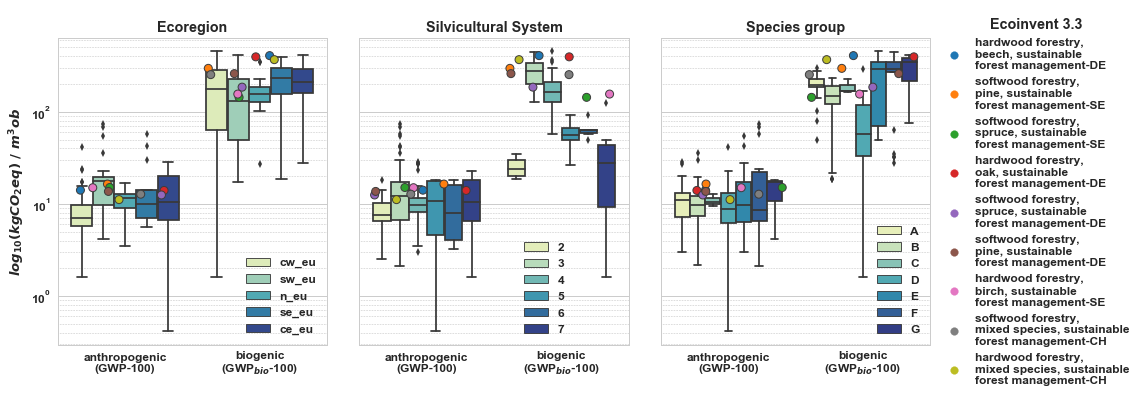

In [13]:
sns.set_context("notebook")

plt.rcParams["font.weight"] = "semibold"
plt.rcParams["axes.labelweight"] = "semibold"
plt.rcParams["axes.titleweight"] = "semibold"
# plt.rcParams["font.size"] = 18
# plt.rcParams["axes.titlesize"] = 18
# plt.rcParams["axes.labelsize"] = 18

sns.set(style="whitegrid", palette="muted",font_scale = 1.2)

    
#hue by code (RIGHT ONE)
fig, axes = plt.subplots(1, 3,figsize=(13, 5), sharey=True)
fig.tight_layout() 
for i,x in enumerate(['Eco_code', 'Man_syst_code', 'Sp_gr_code']):
    ax=sns.boxplot(x="compartment", y="kgco2eq", hue=x, data=box,ax=axes[i],palette='YlGnBu',
                   hue_order=['A','B','C','D','E','F','G'] if x=='Sp_gr_code' else None)#,palette=palettable.tableau.PurpleGray_12.mpl_colors)#,whis=[5, 95]) 
    if i==0:
        ax.set_ylabel('$log_{10}(kgCO_{2}eq)\ /\ m^3 ob$') #set y label name
    else:
        ax.set_ylabel('') #set y label name

    ax.set_xlabel('') #del x label name
    
    #set title
    ax.set_title({k:v for k,v in zip(['Eco_code', 'Man_syst_code', 'Sp_gr_code',],
                                               ['Ecoregion', 'Silvicultural System', 'Species group'])}[x])
    
    #adjust legend
    ax.legend(title='',loc='lower right',frameon=False)
    if i==1:
        ax.legend(title='',loc='lower right',frameon=False,bbox_to_anchor=(0.8, 0))

    ax.grid(True,axis='y',which='minor',ls=":",lw=0.6, color='0.65') #show grid
    
    ax.set(yscale="log")#set log scale
#     sns.despine(offset=10,trim=True)
    
    
    
for y in range(len(axes)):
    ax_scat = axes[y].twiny() #needed when overlaying barplot, see https://stackoverflow.com/a/24237358/4929813
    # st=sns.swarmplot(x="compartment", y="kgco2eq", hue="name", data=scat,ax=ax0, order=['imp_m3','gwpbio_m3']
    #                          , size=8,edgecolor='gray',linewidth=1, marker="X")


    st=sns.stripplot(x="compartment", y="kgco2eq", hue="name", data=scat,ax=ax_scat, order=['imp_m3','gwpbio_m3'],jitter=0.4
                             , size=8,edgecolor='gray',linewidth=1,palette='tab10')#palettable.colorbrewer.qualitative.Set1_9.mpl_colors)
    if y in [0,1]:
        st.legend_.remove() #remove legend
    else:
        leg=st.legend(title='Ecoinvent 3.3',frameon=False,
                 bbox_to_anchor=(1.78, 1.1), loc='upper right')
        #change marker
#         for l in leg.get_lines():
#             l.set_marker('-')

    st.axis('off') #remove axis
    


# sns.despine(offset=10,trim=True)
# plt.yscale('log') #set log scale


# fig.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/first paper questionnarie/manuscript/submitted_EM/impact2.eps', format='eps',dpi=300,bbox_inches='tight')
# fig.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/first paper questionnarie/manuscript/submitted_EM/impact2.svg', format='svg',dpi=300,bbox_inches='tight')
# fig.savefig('/media/giuseppec/25F62A4E5FEED162/work/papers/first paper questionnarie/manuscript/submitted_EM/impact2.pdf', format='pdf',dpi=300,bbox_inches='tight')

print("this graph has been manually post-modified to allign the dots to the relative ecoreg, silv sist and sp groups")

## CHECK DIFFFERENCES IN EXTREME RESULTS

In [42]:

print('ei m3 min and max:',ei.imp_m3.min(),ei.imp_m3.max())
print('ei bio min and max:',ei.gwpbio_m3.min(),ei.gwpbio_m3.max())
print()
print('EFOLCI m3 min and max:',resul.imp_m3.min(),resul.imp_m3.max())
print('EFOLCI bio min and max:',resul.gwpbio_m3.min(),resul.gwpbio_m3.max())

ei m3 min and max: 11.1296911661 16.4336201294
ei bio min and max: 143.598817079 407.672787898

EFOLCI m3 min and max: 0.412465793854 73.1508265954
EFOLCI bio min and max: 1.62592688768 451.926577118


In [22]:

print('ei minimum overall impact:',ei.imp_m3.min() + ei.gwpbio_m3.min())
print('EFOLCI overall  minimum impact:',resul.imp_m3.min() + resul.gwpbio_m3.min())

print('ei overall maximum impact:',ei.imp_m3.max() + ei.gwpbio_m3.max())
print('EFOLCI overall maximum impact:',resul.imp_m3.max() + resul.gwpbio_m3.max())

# print('ei bio min and max:',,ei.gwpbio_m3.max())
# print()
# print('EFOLCI m3 min and max:',resul.imp_m3.min(),resul.imp_m3.max())
# print('EFOLCI bio min and max:',resul.gwpbio_m3.min(),resul.gwpbio_m3.max())

ei minimum overall impact: 154.728508245
EFOLCI overall  minimum impact: 2.03839268154
ei overall maximum impact: 424.106408027
EFOLCI overall maximum impact: 525.077403714


In [56]:
resul.sort_values('imp_both',ascending=True).head()

,Eco_code,Man_syst_code,Sp_gr_code,FoU,imp_m3,gwpbio_m3,imp_both
10,cw_eu,7,D,7-D,5.972008,1.625927,7.597935
57,cw_eu,7,D,7-D,7.105406,1.625927,8.731333
67,cw_eu,2,B,2-B,2.491715,21.910976,24.402692
30,cw_eu,2,B,2-B,2.770365,21.910976,24.681341
27,se_eu,2,B,2-B,7.561515,18.700764,26.262279


In [57]:
resul.sort_values('imp_both',ascending=False).head()

,Eco_code,Man_syst_code,Sp_gr_code,FoU,imp_m3,gwpbio_m3,imp_both
71,sw_eu,3,F,3-F,73.150827,397.839889,470.990716
42,cw_eu,3,F,3-F,24.064775,445.524728,469.589503
17,cw_eu,4,E,4-E,9.138508,451.926577,461.065085
78,se_eu,3,F,3-F,56.895957,397.839889,454.735846
22,sw_eu,3,G,3-G,17.300520,410.040186,427.340705
